# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)



## Introduction: Business Problem <a name="introduction"></a>

In this project, we will try to find an optimal location to live in, using data science tools. Specifically, this report will be targeted to people interested in finding a new place to move in **Mexico City**, Mexico.

Since there are over 1800 neighborhoods in Mexico City, we will try to cluster them by area density and choose one of those clusters arbitrarily for analysis.

The next step will be to cluster the neighborhoods of that specific zone of the city, taking into account factors such as the human development index, seismic risk and proximity to transport, health centers, recreational centers, and markets.

## Data <a name="data"></a>

Based on definition of our problem, factors that will influence our analysis are:
* neighborhood human development index
* neighborhood seismic risk level
* number of and distance to transport stations (trolley, bus and metro)
* number of and distance to health centers (public)
* number of and distance to recreation centers
* number of and distance to markets, supermarkets and hipermarkets

Following data sources will be needed to extract/generate the required information:
* centers of neighborhoods, HDI, Seismic Risk Level and locations of transport stations & public health centers will be obtained from **Mexico City Digital Agency for Public Innovation (ADIP)**
* number of markets & recreation centers and their type and location in every neighborhood will be obtained using **Foursquare API**

### Neighborhood Candidates

#### Mexico City coordinates

Let's first find the latitude & longitude of Mexico city center.

In [1]:
#!pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

In [2]:
geolocator = Nominatim(user_agent="explorer")
location = geolocator.geocode('Mexico City')

# Mexico City latitude and longitude values
latitude = location.latitude
longitude = location.longitude

#### Mexico City neighborhoods geoespatial data

Now let's get latitude & longitude coordinates for centroids and other geospatial data of Mexico City neighborhoods.

In [3]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis

In [4]:
df = pd.read_csv('https://datos.cdmx.gob.mx/explore/dataset/coloniascdmx/download/?format=csv&timezone=America/Mexico_City&use_labels_for_header=true&csv_separator=%2C')
print('CSV file downloaded!') # download file from URL and save it as dataframe

CSV file downloaded!


In [5]:
df.head() # show the first five rows of the dataframe

COLONIA  ENTIDAD  \
0                              IRRIGACION      9.0   
1                 MARINA NACIONAL (U HAB)      9.0   
2              PEDREGAL DE STO DOMINGO VI      9.0   
3  VILLA PANAMERICANA 7MA. SECCIN (U HAB)      9.0   
4  VILLA PANAMERICANA 6TA. SECCIN (U HAB)      9.0   

                      Geo Point  \
0  19.4429549298,-99.2099357048   
1  19.4466319056,-99.1795110575   
2  19.3234027183,-99.1654676133   
3   19.304604269,-99.1677617231   
4  19.3112238873,-99.1696478642   

                                           Geo Shape  CVE_ALC        ALCALDIA  \
0  {"type": "Polygon", "coordinates": [[[-99.2115...       16  MIGUEL HIDALGO   
1  {"type": "Polygon", "coordinates": [[[-99.1797...       16  MIGUEL HIDALGO   
2  {"type": "Polygon", "coordinates": [[[-99.1622...        3        COYOACAN   
3  {"type": "Polygon", "coordinates": [[[-99.1676...        3        COYOACAN   
4  {"type": "Polygon", "coordinates": [[[-99.1702...        3        COYOACAN   

  CVE_COL                      SECC_COM    SECC_PAR  
0  16-035        5079, 5080, 5083, 5102  5068, 5082  
1  16-049                    5137, 5182         NaN  
2  03-144  381, 394, 494, 416, 417, 439         NaN  
3  03-121                           NaN    474, 475  
4  03-120                           NaN         458

In [6]:
# clean up the dataset to remove unnecessary columns
#df.drop(['ENTIDAD','SECC_COM','SECC_PAR'], axis=1, inplace=True)
neigh = df[['CVE_COL','COLONIA','Geo Point','Geo Shape','CVE_ALC','ALCALDIA']]

# rename the columns so that they make sense
neigh.rename(columns={'CVE_COL':'NbhdNumber', 'COLONIA':'Neighborhood', 'ALCALDIA':'Borough', 'CVE_ALC':'BorNumber', 'Geo Shape':'Geojson', 'Geo Point':'GeoPoint'}, inplace=True)

# for sake of consistency, let's also make all column labels of type string
neigh.columns = list(map(str, neigh.columns))

# show the first five rows of the dataframe
#neigh.head()

# new data frame with split value columns 
coord = neigh["GeoPoint"].str.split(",", n = 1, expand = True)
num = neigh["NbhdNumber"].str.split("-", n = 1, expand = True)

# for sake of consistency, let's also make all column labels of type string
coord.columns = list(map(str, coord.columns))
num.columns = list(map(str, num.columns))

# drop old coordinate columns 
neigh.drop(columns=["GeoPoint"], inplace = True)
neigh.drop(columns=["NbhdNumber"], inplace = True)

# separate columns from new data frame and convert data types
neigh.insert(0, "NbhdNumber", pd.to_numeric(num.loc[:,'1']))
neigh.insert(2, "Latitude", pd.to_numeric(coord.loc[:,'0']))
neigh.insert(3, "Longitude", pd.to_numeric(coord.loc[:,'1']))

# show the first five rows of the dataframe
neigh.head()

/Users/uribarra/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)
/Users/uribarra/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


NbhdNumber                            Neighborhood   Latitude  Longitude  \
0          35                              IRRIGACION  19.442955 -99.209936   
1          49                 MARINA NACIONAL (U HAB)  19.446632 -99.179511   
2         144              PEDREGAL DE STO DOMINGO VI  19.323403 -99.165468   
3         121  VILLA PANAMERICANA 7MA. SECCIN (U HAB)  19.304604 -99.167762   
4         120  VILLA PANAMERICANA 6TA. SECCIN (U HAB)  19.311224 -99.169648   

                                             Geojson  BorNumber  \
0  {"type": "Polygon", "coordinates": [[[-99.2115...         16   
1  {"type": "Polygon", "coordinates": [[[-99.1797...         16   
2  {"type": "Polygon", "coordinates": [[[-99.1622...          3   
3  {"type": "Polygon", "coordinates": [[[-99.1676...          3   
4  {"type": "Polygon", "coordinates": [[[-99.1702...          3   

          Borough  
0  MIGUEL HIDALGO  
1  MIGUEL HIDALGO  
2        COYOACAN  
3        COYOACAN  
4        COYOACAN

In [7]:
neigh.shape # return the dimensions of the dataframe

(1812, 7)

In [8]:
neigh.isnull().sum() # get null values

NbhdNumber      0
Neighborhood    0
Latitude        4
Longitude       4
Geojson         4
BorNumber       0
Borough         0
dtype: int64

In [9]:
neigh = neigh.drop(neigh[neigh.isnull().any(axis=1)].index).reset_index(drop=True) # drop raws with null values

print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neigh['Borough'].unique()),
        neigh.shape[0]
    )
)

The dataframe has 16 boroughs and 1808 neighborhoods.


##### First visualization: Mexico City neighborhoods

Let's visualize the data we have so far: Mexico City neigborhoods centers.

In [10]:
#!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

In [11]:
# create map of Mexico City using latitude and longitude values
cdmx_map = folium.Map(location=[latitude, longitude], tiles='cartodbpositron', zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neigh['Latitude'], neigh['Longitude'], neigh['Borough'], neigh['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(cdmx_map)  
    
# display the map of Mexico City
cdmx_map

#### Clustering Mexico City neighborhoods by density

Now let's cluster the Mexico City neighborhoods by area density.

In [12]:
# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

In [13]:
# normalize coordinates
X = neigh.values[:,2:4]
X = np.nan_to_num(X)
X_norm = StandardScaler().fit_transform(X)
X_norm

array([[ 0.86272718, -0.96643957],
       [ 0.90860703, -0.52847215],
       [-0.62899785, -0.32631463],
       ...,
       [-0.43148136,  0.28198025],
       [-0.53742414,  0.29752937],
       [ 0.59607429,  0.53903235]])

In [14]:
# K-means & Elbow method
# The basic idea behind partitioning methods, such as k-means clustering, 
# is to define clusters such that the total intra-cluster variation
# [or total within-cluster sum of square (WSS)] is minimized. The total WSS 
# measures the compactness of the clustering and we want it to be as small as possible.

K = 16 # number pf iterations

# function returns WSS score for k values from 1 to kmax
def calculate_WSS(points, kmax):
  sse = []
  for k in range(1, kmax+1):
    kmeans = KMeans(init = "k-means++", n_clusters = k).fit(points)
    centroids = kmeans.cluster_centers_
    pred_clusters = kmeans.predict(points)
    curr_sse = 0
    
    # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
    for i in range(len(points)):
      curr_center = centroids[pred_clusters[i]]
      curr_sse += (points[i, 0] - curr_center[0]) ** 2 + (points[i, 1] - curr_center[1]) ** 2
      
    sse.append(curr_sse)
  return sse

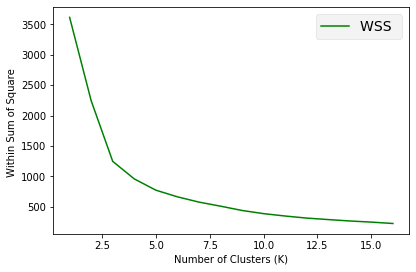

In [15]:
# plot within-cluster sum of square - WSS vs number of clusters - K
plt.plot(range(1, K+1), calculate_WSS(X_norm, K),'g')
plt.style.use('fivethirtyeight')
plt.legend(('WSS ', '+/- 3xstd'))
plt.ylabel('Within Sum of Square ')
plt.xlabel('Number of Clusters (K)')
plt.tight_layout()
plt.savefig('Fig11_KmeansDensity.png')
plt.show()

In [16]:
kclusters = 4 # get value from plot manualliy

In [17]:
# Try to load from local file system in case we did this before
import pickle

loaded_geo = False
try:
    with open('neigh_geo.pkl', 'rb') as f:
        neigh_geo = pickle.load(f)
    print('Geo data loaded.')
    loaded_geo = True
except:
    pass

# If load failed use K-means to get the data
if not loaded_geo:
    neigh_geo = neigh.copy() # new dataframe
    neigh_geo["CityCluster"] = KMeans(init = "k-means++", n_clusters = kclusters).fit(X_norm).labels_ # get clusters labels
    #centroids = KMeans(init = "k-means++", n_clusters = kclusters).fit(X).cluster_centers_ # get clusters centroids    
    
    # Let's persists this in local file system
    with open('neigh_geo.pkl', 'wb') as f:
        pickle.dump(neigh_geo, f)

Geo data loaded.


In [18]:
neigh_geo.head() # show the first five rows of the dataframe

NbhdNumber                            Neighborhood   Latitude  Longitude  \
0          35                              IRRIGACION  19.442955 -99.209936   
1          49                 MARINA NACIONAL (U HAB)  19.446632 -99.179511   
2         144              PEDREGAL DE STO DOMINGO VI  19.323403 -99.165468   
3         121  VILLA PANAMERICANA 7MA. SECCIN (U HAB)  19.304604 -99.167762   
4         120  VILLA PANAMERICANA 6TA. SECCIN (U HAB)  19.311224 -99.169648   

                                             Geojson  BorNumber  \
0  {"type": "Polygon", "coordinates": [[[-99.2115...         16   
1  {"type": "Polygon", "coordinates": [[[-99.1797...         16   
2  {"type": "Polygon", "coordinates": [[[-99.1622...          3   
3  {"type": "Polygon", "coordinates": [[[-99.1676...          3   
4  {"type": "Polygon", "coordinates": [[[-99.1702...          3   

          Borough  CityCluster  
0  MIGUEL HIDALGO            1  
1  MIGUEL HIDALGO            1  
2        COYOACAN            0  
3        COYOACAN            0  
4        COYOACAN            0

In [19]:
# Count number of neighborhoods per cluster
neigh_geo.groupby(['CityCluster']).CityCluster.agg('count').to_frame('Count').reset_index()

CityCluster  Count
0            0    409
1            1    583
2            2    442
3            3    374

Let's create a new dataframe which will contaiin the final structured data to be analyzed.

In [20]:
data = neigh_geo.copy()

#### Mexico City neighborhoods Human Development Index

Now let's get the HDI of Mexico City neighborhoods.

In [21]:
df1 = pd.read_excel('http://evalua.cdmx.gob.mx/storage/app/media/uploaded-files/files/Atribuciones/unidades-territoriales/ids_colonia_2010f.xlsx', header=1) 
print('XLSX file downloaded!') # download file from URL and save it as dataframe

XLSX file downloaded!


In [22]:
df1.head() # show the first five rows of the dataframe

Folio  Clave de Delegación Clave  de Delegación  Clave de Colonia o Barrio  \
0    NaN                  NaN                  NaN                        NaN   
1  20001                  2.0         Azcapotzalco                        1.0   
2  20002                  2.0         Azcapotzalco                        2.0   
3  20003                  2.0         Azcapotzalco                        3.0   
4  20004                  2.0         Azcapotzalco                        4.0   

                  Colonia  Habitantes  Valor IDS CDMX Estrato  \
0                     NaN         NaN             NaN     NaN   
1                Aguilera      2014.0        0.831271   Medio   
2                  Aldana      3228.0        0.806776   Medio   
3  Ampliación Cosmopolita       992.0        0.876616   Medio   
4      Ampliación Del Gas      1254.0        0.822526   Medio   

  Índice de Desarrollo Social de la Ciudad de México 2010, por Componente (Valor)  \
0                   Calidad y espacio de la vivienda                                
1                                           0.697741                                
2                                           0.644284                                
3                                            0.74874                                
4                                           0.688198                                

                          Unnamed: 9       Unnamed: 10      Unnamed: 11  \
0  Acceso a salud y seguridad social  Rezago educativo  Bienes durables   
1                           0.635072          0.954751         0.901265   
2                           0.645227          0.957458         0.929145   
3                            0.71938          0.972592          0.92629   
4                           0.701289          0.955125         0.948418   

            Unnamed: 12            Unnamed: 13  \
0  Adecuación sanitaria  Adecuación energética   
1              0.908557               0.997517   
2              0.925651                      1   
3              0.960685                      1   
4              0.859516                      1   

  Índice de Desarrollo Social de la Ciudad de México 2010, por Componente (Estrato)  \
0                   Calidad y espacio de la vivienda                                  
1                                           Muy bajo                                  
2                                           Muy bajo                                  
3                                               Bajo                                  
4                                           Muy bajo                                  

                         Unnamed: 15       Unnamed: 16      Unnamed: 17  \
0  Acceso a salud y seguridad social  Rezago educativo  Bienes durables   
1                           Muy bajo              Alto             Alto   
2                           Muy bajo              Alto             Alto   
3                               Bajo              Alto             Alto   
4                               Bajo              Alto             Alto   

            Unnamed: 18            Unnamed: 19  
0  Adecuación sanitaria  Adecuación energética  
1                  Alto                   Alto  
2                  Alto                   Alto  
3                  Alto                   Alto  
4                 Medio                   Alto

In [23]:
# clean up the dataset to remove unnecessary columns
hdi = df1[['Clave de Delegación','Clave de Colonia o Barrio','Valor IDS CDMX']]

# rename the columns so that they make sense
hdi.rename(columns={'Clave de Delegación':'BorNumber', 'Clave de Colonia o Barrio':'NbhdNumber', 'Valor IDS CDMX':'HDI_2010'}, inplace=True)

# for sake of consistency, let's also make all column labels of type string
hdi.columns = list(map(str, hdi.columns))

# drop unnecesary rows
hdi = hdi.drop([0, hdi.shape[0]-1], axis=0).reset_index(drop=True)

# change data type
hdi['BorNumber'] = hdi['BorNumber'].astype(int)
hdi['NbhdNumber'] = hdi['NbhdNumber'].astype(int)

# show the first five rows of the dataframe
hdi.head()

/Users/uribarra/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


BorNumber  NbhdNumber  HDI_2010
0          2           1  0.831271
1          2           2  0.806776
2          2           3  0.876616
3          2           4  0.822526
4          2           5  0.914462

Now let's merge the HDI data with the geospatial data.

In [24]:
data = pd.merge(data, hdi, how='left', on=['BorNumber','NbhdNumber'])
data.set_index(['BorNumber', 'NbhdNumber'], inplace=True)
data.sort_index(inplace=True)

data.head()

Neighborhood   Latitude  Longitude  \
BorNumber NbhdNumber                                               
2         1                       AGUILERA  19.472845 -99.155746   
          2                         ALDANA  19.470737 -99.149997   
          3           AMPLIACION PETROLERA  19.483038 -99.195313   
          5                  ANGEL ZIMBRON  19.467794 -99.189118   
          6                         ARENAL  19.465294 -99.152009   

                                                                Geojson  \
BorNumber NbhdNumber                                                      
2         1           {"type": "Polygon", "coordinates": [[[-99.1590...   
          2           {"type": "Polygon", "coordinates": [[[-99.1485...   
          3           {"type": "Polygon", "coordinates": [[[-99.1966...   
          5           {"type": "Polygon", "coordinates": [[[-99.1904...   
          6           {"type": "Polygon", "coordinates": [[[-99.1518...   

                           Borough  CityCluster  HDI_2010  
BorNumber NbhdNumber                                       
2         1           AZCAPOTZALCO            1  0.831271  
          2           AZCAPOTZALCO            1  0.806776  
          3           AZCAPOTZALCO            1  0.876616  
          5           AZCAPOTZALCO            1  0.914462  
          6           AZCAPOTZALCO            1  0.727231

Since there are null values in the HDI column, we will fill them with the borough mean HDI value.

In [25]:
data.isnull().sum() # get null values

Neighborhood      0
Latitude          0
Longitude         0
Geojson           0
Borough           0
CityCluster       0
HDI_2010        548
dtype: int64

Let's get the mean HDI by borough and replace null HDI values with them:

In [26]:
# Find the mean HDI by borough
hdi_bor = hdi[['BorNumber','HDI_2010']].groupby('BorNumber').mean().reset_index()

hdi_bor

BorNumber  HDI_2010
0           2  0.843458
1           3  0.906057
2           4  0.775019
3           5  0.799916
4           6  0.818111
5           7  0.752449
6           8  0.769113
7           9  0.641525
8          10  0.791709
9          11  0.727186
10         12  0.823979
11         13  0.740239
12         14  0.946385
13         15  0.872688
14         16  0.887186
15         17  0.821903

In [27]:
# Replace HDI null values
zeros = data.index[data['HDI_2010'].isna()]

for i in range(len(zeros)):
    mean = hdi_bor['HDI_2010'][hdi_bor['BorNumber']==zeros[i][0]].values
    data.loc[zeros[i],'HDI_2010'] =  mean
               
#data.loc[zeros]
data.isnull().sum() # check result

Neighborhood    0
Latitude        0
Longitude       0
Geojson         0
Borough         0
CityCluster     0
HDI_2010        0
dtype: int64

#### Mexico City Seismic Risk Atlas

Now let's get the Mexico City seismic risk data.

In [28]:
df2 = pd.read_csv('https://datos.cdmx.gob.mx/explore/dataset/atlas-de-riesgo-sismico/download/?format=csv&timezone=America/Mexico_City&lang=es&use_labels_for_header=true&csv_separator=%2C') 
print('CSV file downloaded!') # download file from URL and save it as dataframe

CSV file downloaded!


In [29]:
df2.head(1) # show the first row of the dataframe

Geopoint  \
0  19.5279442108,-99.1516653293   

                                            Geoshape      ID    Fenómeno  \
0  {"type": "Polygon", "coordinates": [[[-99.1526...  1388.0  Geológicos   

  Taxonomía     Rpve Intensidad  \
0   Sísmico  Peligro      Medio   

                                         Descripción  \
0  AGEB localizado en las partes más altas de la ...   

                                              Fuente         Cvegeo  \
0  Dirección de Análisis de Riesgo de la SPCGIR, ...  0900500010281   

            Alcaldía           Entidad      Área mt2    Perímetro  int2  
0  Gustavo A. Madero  Ciudad de México  86829.116024  1317.604289     3

In [30]:
# clean up the dataset to remove unnecessary columns
risk = df2[['Geopoint','Intensidad']]

# rename the columns so that they make sense
risk.rename(columns={'Geopoint':'GeoPoint', 'Intensidad':'SeismicRiskLevel'}, inplace=True)

# for sake of consistency, let's also make all column labels of type string
risk.columns = list(map(str, risk.columns))

# new data frame with split value columns 
coord = risk["GeoPoint"].str.split(",", n = 1, expand = True)

# for sake of consistency, let's also make all column labels of type string
coord.columns = list(map(str, coord.columns))

# drop old coordinate columns 
risk.drop(columns=["GeoPoint"], inplace = True)

# separate columns from new data frame and convert data types
risk.insert(0, "LatitudeRisk", pd.to_numeric(coord.loc[:,'0']))
risk.insert(1, "LongitudeRisk", pd.to_numeric(coord.loc[:,'1']))

# replace word scale with numeric scale
words = risk['SeismicRiskLevel'].unique()
vals = list(range(0,len(words))) # [::-1] reverse values
mapping = dict(list(zip(words, vals)))
risk = risk.replace({'SeismicRiskLevel': mapping})

# show the first five rows of the dataframe
risk.head()

/Users/uribarra/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


LatitudeRisk  LongitudeRisk  SeismicRiskLevel
0     19.527944     -99.151665                 0
1     19.469757     -99.146398                 1
2     19.463335     -99.186439                 1
3     19.403236     -99.088982                 2
4     19.475694     -99.095639                 2

Since risk coordinates didn't correspond to neighborhood coordinates, we will apply a classification algorithm to find the seismic risk value per neighborhood.

In [31]:
from sklearn.model_selection import train_test_split

In [32]:
# neighborhoods coordinates
neigh_risk = neigh[['BorNumber','NbhdNumber','Latitude','Longitude']]

In [33]:
# features: Latitude & Longitude
feature_df = risk[['LatitudeRisk', 'LongitudeRisk']]
X = np.asarray(feature_df)
X[0:5]

array([[ 19.52794421, -99.15166533],
       [ 19.46975694, -99.14639815],
       [ 19.46333494, -99.18643916],
       [ 19.40323622, -99.08898225],
       [ 19.47569433, -99.09563879]])

We want the model to predict the value of Risk (that is, Medium  (=0), High (=1), or Very High (=2). This field can have one of those 3 possible values.

In [34]:
# classes: Seismic risk levels
y = np.asarray(risk['SeismicRiskLevel'])
y[0:5]

array([0, 1, 1, 2, 2])

Okay, we split our dataset into train and test set:

In [35]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (3926, 2) (3926,)
Test set: (982, 2) (982,)


Let's use KNN algorithm.

In [36]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [37]:
Ks = 10 # number pf iterations

# function returns mean accuracy score for k values from 1 to kmax
def calculate_ACC(X_train, y_train, kmax):
    mean_acc = np.zeros((Ks-1))
    std_acc = np.zeros((Ks-1))
    for n in range(1,Ks):

        #Train Model and Predict  
        neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
        yhat=neigh.predict(X_test)
        mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)
        std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
    acc = mean_acc[1:].max()
    k = mean_acc[1:].argmax()+1
    knn = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
    return mean_acc, acc, k, knn

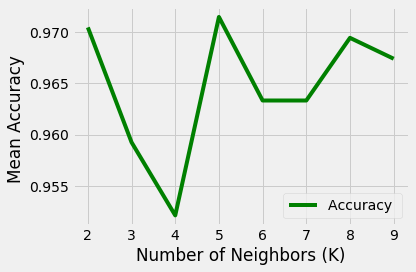

The best accuracy was 0.9714867617107943 with k = 4


In [38]:
# plot within-cluster sum of square - WSS vs number of clusters - K
mean_acc, acc, k, knn = calculate_ACC(X_train, y_train, Ks)
plt.plot(range(2,Ks), mean_acc[1:],'g')
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Mean Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.savefig('Fig10_KNNSeismic.png')
plt.show()
print( "The best accuracy was", acc, "with k =", k)

Now let's predict the seismic risk for the neighborhoods coordinates.

In [39]:
# features: Latitude & Longitude
X_neigh = np.asarray(neigh_risk[['Latitude', 'Longitude']])
risk_level = knn.predict(X_neigh)
risk_level[0:5]

array([0, 1, 0, 0, 0])

In [40]:
neigh_risk = neigh_risk[['BorNumber','NbhdNumber']]
neigh_risk['SeismicRiskLevel'] = risk_level

neigh_risk.head()

BorNumber  NbhdNumber  SeismicRiskLevel
0         16          35                 0
1         16          49                 1
2          3         144                 0
3          3         121                 0
4          3         120                 0

Now let's merge the seismic data with the structured data we have so far.

In [41]:
data = pd.merge(data, neigh_risk, how='left', on=['BorNumber','NbhdNumber'])
data.set_index(['BorNumber', 'NbhdNumber'], inplace=True)
data.sort_index(inplace=True)

data.head()

Neighborhood   Latitude  Longitude  \
BorNumber NbhdNumber                                               
2         1                       AGUILERA  19.472845 -99.155746   
          2                         ALDANA  19.470737 -99.149997   
          3           AMPLIACION PETROLERA  19.483038 -99.195313   
          5                  ANGEL ZIMBRON  19.467794 -99.189118   
          6                         ARENAL  19.465294 -99.152009   

                                                                Geojson  \
BorNumber NbhdNumber                                                      
2         1           {"type": "Polygon", "coordinates": [[[-99.1590...   
          2           {"type": "Polygon", "coordinates": [[[-99.1485...   
          3           {"type": "Polygon", "coordinates": [[[-99.1966...   
          5           {"type": "Polygon", "coordinates": [[[-99.1904...   
          6           {"type": "Polygon", "coordinates": [[[-99.1518...   

                           Borough  CityCluster  HDI_2010  SeismicRiskLevel  
BorNumber NbhdNumber                                                         
2         1           AZCAPOTZALCO            1  0.831271                 1  
          2           AZCAPOTZALCO            1  0.806776                 1  
          3           AZCAPOTZALCO            1  0.876616                 1  
          5           AZCAPOTZALCO            1  0.914462                 1  
          6           AZCAPOTZALCO            1  0.727231                 1

#### Mexico City Public Transport & Health Centers data

Let's get the Mexico City public transport and Health Centers data.

In [42]:
df3 = pd.read_csv('https://datos.cdmx.gob.mx/explore/dataset/estaciones-metrobus/download/?format=csv&timezone=America/Mexico_City&lang=es&use_labels_for_header=true&csv_separator=%2C') 
df4 = pd.read_csv('https://datos.cdmx.gob.mx/explore/dataset/estaciones-metro/download/?format=csv&timezone=America/Mexico_City&lang=es&use_labels_for_header=true&csv_separator=%2C') 
df5 = pd.read_csv('https://datos.cdmx.gob.mx/explore/dataset/hospitales-y-centros-de-salud/download/?format=csv&timezone=America/Mexico_City&lang=es&use_labels_for_header=true&csv_separator=%2C') 
df6 = pd.read_csv('https://datos.cdmx.gob.mx/explore/dataset/paradas-de-trolebus/download/?format=csv&timezone=America/Mexico_City&lang=es&use_labels_for_header=true&csv_separator=%2C') 

print('CSV files downloaded!') # download file from URL and save it as dataframe

CSV files downloaded!


In [43]:
df3.head(1) # show the first row of the dataframe

wkt_geom   Nombre    Línea  \
0  PointZ (-99.17009699999999839 19.2803590000000...  La Joya  Línea 1   

    Longitud    Latitud              Geopoint  
0 -99.170097  19.280359  19.280359,-99.170097

In [44]:
df4.head(1) # show the first row of the dataframe

Geometry  stop_id  stop_code  \
0  {"type": "Point", "coordinates": [-99.10281658...  14172.0        NaN   

  stop_name stop_desc   stop_lat   stop_lon                trip_heads  \
0  Balbuena   Metro 1  19.422887 -99.102817  Observatorio - Pantitlán   

  agency_id                  Geopoint  
0     METRO  19.42288725,-99.10281658

In [45]:
df5.head(1) # show the first row of the dataframe

Nombre  \
0  Hospital Pediátrico Iztapalapa   

                                             Titular    Latitud   Longitud  \
0  Director: Dr. Ramón Carballo Herrada Dirección...  19.356548 -99.107689   

                     Coordenadas              Geopoint  
0  -99.107689,19.356548,0.000000  19.356548,-99.107689

In [46]:
df6.head(1) # show the first row of the dataframe

Geometry  stop_id  stop_code  \
0  {"type": "Point", "coordinates": [-99.14981363...  18116.0        NaN   

   stop_name    stop_desc   stop_lat   stop_lon  \
0  AMÉRICA_1  EJE Central  19.345546 -99.149814   

                                          trip_heads agency_id  \
0  Central de Autobuses del Norte - Central de Au...       STE   

                            route_long             geo_point_2d  
0  Corredor Cero Emisiones Eje Central  19.3455455,-99.14981363

In [47]:
# clean up the dataset to remove unnecessary columns
bus = df3[['Nombre','Geopoint','Línea']]
metro = df4[['stop_name','Geopoint','trip_heads']]
health = df5[['Nombre','Geopoint']]
trolley = df6[['stop_name','geo_point_2d','trip_heads']]

# rename the columns so that they make sense
bus.rename(columns={'Geopoint':'GeoPoint', 'Nombre':'Station','Línea':'Line'}, inplace=True)
metro.rename(columns={'Geopoint':'GeoPoint','stop_name':'Station','trip_heads':'Line'}, inplace=True)
trolley.rename(columns={'geo_point_2d':'GeoPoint','stop_name':'Station','trip_heads':'Line'}, inplace=True)
health.rename(columns={'Geopoint':'GeoPoint', 'Nombre':'HealthCentre'}, inplace=True)

# new data frame with split value columns 
coord1 = bus["GeoPoint"].str.split(",", n = 1, expand = True)
coord2 = metro["GeoPoint"].str.split(",", n = 1, expand = True)
coord3 = health["GeoPoint"].str.split(",", n = 1, expand = True)
coord4 = trolley["GeoPoint"].str.split(",", n = 1, expand = True)

# for sake of consistency, let's also make all column labels of type string
coord1.columns = list(map(str, coord.columns))
coord2.columns = list(map(str, coord2.columns))
coord3.columns = list(map(str, coord3.columns))
coord4.columns = list(map(str, coord4.columns))

# drop old coordinate columns 
bus.drop(columns=["GeoPoint"], inplace = True)
metro.drop(columns=["GeoPoint"], inplace = True)
health.drop(columns=["GeoPoint"], inplace = True)
trolley.drop(columns=["GeoPoint"], inplace = True)

# separate columns from new data frame and convert data types
bus.insert(0, "Latitude", pd.to_numeric(coord1.loc[:,'0']))
bus.insert(1, "Longitude", pd.to_numeric(coord1.loc[:,'1']))
metro.insert(0, "Latitude", pd.to_numeric(coord2.loc[:,'0']))
metro.insert(1, "Longitude", pd.to_numeric(coord2.loc[:,'1']))
health.insert(0, "Latitude", pd.to_numeric(coord3.loc[:,'0']))
health.insert(1, "Longitude", pd.to_numeric(coord3.loc[:,'1']))
trolley.insert(0, "Latitude", pd.to_numeric(coord4.loc[:,'0']))
trolley.insert(1, "Longitude", pd.to_numeric(coord4.loc[:,'1']))

/Users/uribarra/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)
/Users/uribarra/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [48]:
bus.shape

(234, 4)

In [49]:
metro.shape

(195, 4)

In [50]:
trolley.shape

(596, 4)

In [51]:
bus.insert(0,'Transport','Bus')
metro.insert(0,'Transport','Metro')
trolley.insert(0,'Transport','Trolley')

transport = pd.concat([metro,bus,trolley])

transport.head()# show the first row of the dataframe

Transport   Latitude  Longitude       Station                         Line
0     Metro  19.422887 -99.102817      Balbuena     Observatorio - Pantitlán
1     Metro  19.451014 -99.095982        Aragón      Pantitlán - Politécnico
2     Metro  19.376256 -99.187746     Mixcoac_1            Tláhuac - Mixcoac
3     Metro  19.440482 -99.094201  Romero Rubio   Buenavista - Ciudad Azteca
4     Metro  19.505229 -99.199483  El Rosario_1  Martín Carrera - El Rosario

In [52]:
health.head(1) # show the first row of the dataframe

Latitude  Longitude                    HealthCentre
0  19.356548 -99.107689  Hospital Pediátrico Iztapalapa

In [53]:
health.shape

(27, 3)

Our neighborhoods will be defined as circular areas with a radius of 1000 meters for transport stations and 5000 meters for health centers.

To accurately calculate distances we need to create our grid of locations in Cartesian 2D coordinate system which allows us to calculate distances in meters (not in latitude/longitude degrees). Then we'll project those coordinates back to latitude/longitude degrees to be shown on Folium map. So let's create functions to convert between WGS84 spherical coordinate system (latitude/longitude degrees) and UTM Cartesian coordinate system (X/Y coordinates in  meters).

In [54]:
r_transport = 1000 # meters
r_health = 5000 # meters

In [55]:
#!pip install shapely
import shapely.geometry

#!pip install pyproj
import pyproj

import math

In [56]:
# Convert latitude/longitude degrees to meters
def lonlat_to_xy(coords):
    coordsxy = []
    for coord in coords:
        lon, lat = coord
        proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
        proj_xy = pyproj.Proj(proj="utm", zone=33, datum='WGS84')
        xy = pyproj.transform(proj_latlon, proj_xy, lon, lat)
        coordsxy.append(xy)
    return coordsxy

# Convert metres to latitude/longitude degrees
def xy_to_lonlat(coordsxy):
    coords = []
    for coord in coordsxy:
        x, y = coord
        proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
        proj_xy = pyproj.Proj(proj="utm", zone=33, datum='WGS84')
        lonlat = pyproj.transform(proj_xy, proj_latlon, x, y)
        coords.append(lonlat)
    return coords

# Compute the distance between points and a reference point
def calc_xy_distance(center, points):
    center = np.array(center)
    points = np.array(points)
    dist = np.linalg.norm(points-center, axis=1)
    return dist

# Find if a point is within a circle
def in_circle(radius, distances):
    return distances <= radius

# Count the number of points around a reference point
def near_places(references, places, radius):
    number = []
    centersxy = lonlat_to_xy(references)
    placesxy = lonlat_to_xy(places)
    for center in centersxy:
        dist = calc_xy_distance(center, placesxy)
        incircle = in_circle(radius, dist)
        num = np.count_nonzero(incircle)
        number.append(num)
    return number

# Find distance to nearest place around a reference point
def distance_nearest_place(references, places):
    nearest = []
    centersxy = lonlat_to_xy(references)
    placesxy = lonlat_to_xy(places)
    for center in centersxy:
        dist = calc_xy_distance(center, placesxy)
        nearest.append(min(dist))
    return nearest

print('Coordinate transformation check')
print('-------------------------------')
print('Mexico City center longitude = {}, latitude = {}'.format(longitude, latitude))
x, y = lonlat_to_xy([(longitude, latitude)])[0]
print('Mexico City center UTM X = {}, Y = {}'.format(x, y))
lo, la = xy_to_lonlat([(x, y)])[0]
print('Mexico City center longitude = {}, latitude = {}'.format(lo, la))

Coordinate transformation check
-------------------------------
Mexico City center longitude = -99.1331785, latitude = 19.4326296
Mexico City center UTM X = -7767618.8890201785, Y = 15450077.147281328
Mexico City center longitude = -99.13317849995293, latitude = 19.432629600004113


Let's structure our raw transport & health data.

In [57]:
# Sets of coordinates
near = neigh[['BorNumber','NbhdNumber']]
coords_neigh = neigh[['Longitude', 'Latitude']].values # Neighborhood coordinates (reference points)
coords_transp = transport[['Longitude', 'Latitude']].values # Transport stations coordinates
coords_health = health[['Longitude', 'Latitude']].values # Health centers coordinates

OK, now let's count the **number of transport stations & health centers in every neighborhood candidate** and calculate the **distance to transport station & health center from every neighborhood candidate center**.

In [58]:
transport_stations_count = near_places(coords_neigh, coords_transp, r_transport)
near.insert(2, "TransportStations", transport_stations_count)
near.insert(3, "DistanceTranspStation", distance_nearest_place(coords_neigh, coords_transp))

health_centers_count = near_places(coords_neigh, coords_health, r_health)
near.insert(4, "HealthCenters", health_centers_count)
near.insert(5, "DistanceHealthCenter", distance_nearest_place(coords_neigh, coords_health))

In [59]:
near.head()

BorNumber  NbhdNumber  TransportStations  DistanceTranspStation  \
0         16          35                  0            3505.525239   
1         16          49                  6             618.279328   
2          3         144                  0            1793.724712   
3          3         121                  0            3309.556192   
4          3         120                  0            3002.540521   

   HealthCenters  DistanceHealthCenter  
0              1           2223.364083  
1              2           2331.067514  
2              1           4891.461736  
3              0           8968.644807  
4              0           7535.202415

In [60]:
print('Average number of transport stataions in every neighborhood in Mexico City with radius=1000m:', np.array(transport_stations_count).mean())
print('Average distance to closest trasnport station from each neighborhood center:', near['DistanceTranspStation'].mean(),'m')

print('Average number of health centers in every neighborhood in Mexico City with radius=5000m:', np.array(health_centers_count).mean())
print('Average distance to closest health center from each neighborhood center:', near['DistanceHealthCenter'].mean(),'m')

Average number of transport stataions in every neighborhood in Mexico City with radius=1000m: 1.2007743362831858
Average distance to closest trasnport station from each neighborhood center: 4133.061731989098 m
Average number of health centers in every neighborhood in Mexico City with radius=5000m: 0.7588495575221239
Average distance to closest health center from each neighborhood center: 5593.80957734821 m


Now let's merge the transport & health data with the structured data we have so far.

In [61]:
data = pd.merge(data, near, how='left', on=['BorNumber','NbhdNumber'])
data.set_index(['BorNumber', 'NbhdNumber'], inplace=True)
data.sort_index(inplace=True)

data.head()

Neighborhood   Latitude  Longitude  \
BorNumber NbhdNumber                                               
2         1                       AGUILERA  19.472845 -99.155746   
          2                         ALDANA  19.470737 -99.149997   
          3           AMPLIACION PETROLERA  19.483038 -99.195313   
          5                  ANGEL ZIMBRON  19.467794 -99.189118   
          6                         ARENAL  19.465294 -99.152009   

                                                                Geojson  \
BorNumber NbhdNumber                                                      
2         1           {"type": "Polygon", "coordinates": [[[-99.1590...   
          2           {"type": "Polygon", "coordinates": [[[-99.1485...   
          3           {"type": "Polygon", "coordinates": [[[-99.1966...   
          5           {"type": "Polygon", "coordinates": [[[-99.1904...   
          6           {"type": "Polygon", "coordinates": [[[-99.1518...   

                           Borough  CityCluster  HDI_2010  SeismicRiskLevel  \
BorNumber NbhdNumber                                                          
2         1           AZCAPOTZALCO            1  0.831271                 1   
          2           AZCAPOTZALCO            1  0.806776                 1   
          3           AZCAPOTZALCO            1  0.876616                 1   
          5           AZCAPOTZALCO            1  0.914462                 1   
          6           AZCAPOTZALCO            1  0.727231                 1   

                      TransportStations  DistanceTranspStation  HealthCenters  \
BorNumber NbhdNumber                                                            
2         1                           4             335.854707              1   
          2                           4             561.212246              1   
          3                           0            1149.066016              2   
          5                           1             324.554759              2   
          6                           0            1669.541636              2   

                      DistanceHealthCenter  
BorNumber NbhdNumber                        
2         1                    4091.756843  
          2                    2938.889240  
          3                    2025.007592  
          5                    3700.616048  
          6                    2519.392808

### Choosing one City Cluster

Since we have clustered the Mexico City neigborhoods by area density, we will choose one of those clusters arbitrarily for analysis in order to not exceed the limit of Forsquare daily requests. For instance, let's select that zone which contains the well-known Mexico City Main Square: The Zocalo (CENTRO IV).

In [62]:
# Select a cluster arbitrarily
geo_cluster = data[data['Neighborhood'] == 'CENTRO IV']['CityCluster'].values[0]
cdmx_central = data[data['CityCluster'] == geo_cluster]#.reset_index()
cdmx_central.head(1)

Neighborhood   Latitude  Longitude  \
BorNumber NbhdNumber                                      
2         1              AGUILERA  19.472845 -99.155746   

                                                                Geojson  \
BorNumber NbhdNumber                                                      
2         1           {"type": "Polygon", "coordinates": [[[-99.1590...   

                           Borough  CityCluster  HDI_2010  SeismicRiskLevel  \
BorNumber NbhdNumber                                                          
2         1           AZCAPOTZALCO            1  0.831271                 1   

                      TransportStations  DistanceTranspStation  HealthCenters  \
BorNumber NbhdNumber                                                            
2         1                           4             335.854707              1   

                      DistanceHealthCenter  
BorNumber NbhdNumber                        
2         1                    4091.756843

Let's get the cluster centroids:

In [63]:
# Find the mean HDI by borough
centroids = data[['CityCluster','Latitude','Longitude']].groupby('CityCluster').mean()#.reset_index()
centroids

Latitude  Longitude
CityCluster                      
0            19.298386 -99.140007
1            19.467593 -99.139209
2            19.353728 -99.229560
3            19.333848 -99.048915

Now let's find the latitude & longitude of the centroid of Mexico City central area...

In [64]:
# Mexico City west zone latitude and longitude values
latitude_c, longitude_c = centroids.loc[geo_cluster].values

and let's visualize it.

In [65]:
# create map of Mexico City using latitude and longitude values
cdmx_map_2 = folium.Map(location=[latitude_c, longitude_c], tiles='cartodbpositron', zoom_start=11)

# add markers to map
for lat, lng, borough, neighborhood, index, riskk, tran, healthc  in zip(cdmx_central['Latitude'], cdmx_central['Longitude'], cdmx_central['Borough'], cdmx_central['Neighborhood'], cdmx_central['HDI_2010'], cdmx_central['SeismicRiskLevel'], cdmx_central['TransportStations'], cdmx_central['HealthCenters']):
    label = 'Borough: {}, Neighborhhood: {}, HDI: {}, Seismic Risk: {}, Nearby Transport Stations: {}, Nearby Public Health Centers: {}.'.format(borough, neighborhood, index, riskk, tran, healthc)
    #label = 'Borough: {}, Neighborhhood: {}'.format(borough, neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(cdmx_map_2)  
    
# display the map of Mexico City
cdmx_map_2

### Foursquare
Now that we have our location candidates, let's use Foursquare API to get info on markets and recreation centers in each neighborhood.

We're interested in venues in 'Food and drink shop' category, but only those that are proper places to get food supplies, and also in all venues in 'Art and entertainment' category.

In [66]:
import json, requests

In [67]:
limit_venues = 25

In [68]:
latitudes = cdmx_central['Latitude']
longitudes = cdmx_central['Longitude']

In [70]:
# Category IDs corresponding to foos shops were taken from Foursquare web site (https://developer.foursquare.com/docs/resources/categories):

shops_category = '4d4b7105d754a06378d81259' # 'Root' category for all foodshops-related venues

foodshops_categories = ['4bf58dd8d48988d11d951735','4bf58dd8d48988d11e951735','58daa1558bbb0b01f18ec1ca',
                        '4bf58dd8d48988d1fa941735','4bf58dd8d48988d10e951735','56aa371be4b08b9a8d573550',
                        '4bf58dd8d48988d1f5941735','4bf58dd8d48988d118951735','50aa9e744b90af0d42d5de0e',
                        '52f2ab2ebcbc57f1066b8b45','56aa371be4b08b9a8d573564','52f2ab2ebcbc57f1066b8b46',
                        '50be8ee891d4fa8dcc7199a7','4bf58dd8d48988d1fd941735','52f2ab2ebcbc57f1066b8b42']

recreation_category = '4d4b7104d754a06370d81259' # 'Root' category for all art & entertainment-related venues

recreation_categories = ['56aa371be4b08b9a8d5734db','4fceea171983d5d06c3e9823','5032792091d4c4b30a586d5c',
                        '4bf58dd8d48988d1e2931735','56aa371be4b08b9a8d573532','4bf58dd8d48988d1f1931735',
                        '4deefb944765f83613cdba6e','4bf58dd8d48988d17f941735','4bf58dd8d48988d181941735',
                        '4bf58dd8d48988d1e5931735','4bf58dd8d48988d1f2931735','4bf58dd8d48988d184941735',
                        '4bf58dd8d48988d182941735','4bf58dd8d48988d193941735','4bf58dd8d48988d17b941735']

def is_shop(categories, specific_filter=None):
    shop = False
    specific = False
    for c in categories:
        category_id = c[1]
        if not(specific_filter is None) and (category_id in specific_filter):
            specific = True
            shop = True
    return shop, specific

def get_categories(categories):
    return [(cat['name'], cat['id']) for cat in categories]

def get_venues_near_location(lat, lon, category, client_id, client_secret, radius, limit):
    version = '20180605'
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
        client_id, client_secret, version, lat, lon, category, radius, limit)
    try:
        results = requests.get(url).json()['response']['groups'][0]['items']
        venues = [(item['venue']['id'],
                   item['venue']['name'],
                   get_categories(item['venue']['categories']),
                   (item['venue']['location']['lat'], item['venue']['location']['lng']),
                   item['venue']['location']['distance']) for item in results]        
    except:
        venues = []
    return venues

In [71]:
def get_venues(lats, lons, venues_category, venues_filter, radius, limit):
    shops = {}
    food_shops = {}
    location_shops= []
    
    print('Obtaining venues around candidate locations:', end='')
    for lat, lon in zip(lats, lons):
        venues = get_venues_near_location(lat, lon, venues_category, foursquare_client_id, foursquare_client_secret, radius, limit)
        area_shops = []
        for venue in venues:
            venue_id = venue[0]
            venue_name = venue[1]
            venue_categories = venue[2]
            venue_latlon = venue[3]
            venue_distance = venue[4]
            is_sh, is_food = is_shop(venue_categories, specific_filter=venues_filter)
            if is_sh:
                xy = lonlat_to_xy([venue_latlon[::-1]])[0]
                shop = (venue_id, venue_name, venue_latlon[0], venue_latlon[1], venue_distance, is_food, xy[0], xy[1])
                if venue_distance<=0.9*radius:
                    area_shops.append(shop)
                shops[venue_id] = shop
                if is_food:
                    food_shops[venue_id] = shop
        location_shops.append(area_shops)
        print(' .', end='')
    print(' done.')
    return shops, food_shops, location_shops

#### Food Shops

Let's get info on food shops in every neighborhood in Northern Central Mexico City.

In [72]:
radius_foodshops = 1000 # meters

In [73]:
# Try to load from local file system in case we did this before
shops = {}
food_shops = {}
location_shops= []
loaded_shops = False
try:
    with open('shops.pkl', 'rb') as f:
        shops = pickle.load(f)
    with open('food_shops.pkl', 'rb') as f:
        food_shops = pickle.load(f)
    with open('location_shops.pkl', 'rb') as f:
        location_shops = pickle.load(f)
    print('Shop data loaded.')
    loaded_shops = True
except:
    pass

# If load failed use the Foursquare API to get the data
if not loaded_shops:
    shops, food_shops, location_shops = get_venues(latitudes, longitudes, shops_category, foodshops_categories, radius_foodshops, limit_venues)
    
    # Let's persists this in local file system
    with open('shops.pkl', 'wb') as f:
        pickle.dump(shops, f)
    with open('food_shops.pkl', 'wb') as f:
        pickle.dump(food_shops, f)
    with open('location_shops.pkl', 'wb') as f:
        pickle.dump(location_shops, f)

Shop data loaded.


In [74]:
print('Total number of shops:', len(shops))
print('Total number of food shops:', len(food_shops))
print('Percentage of food shops: {:.2f}%'.format(len(food_shops) / len(shops) * 100))
print('Average number of shops in neighborhood:', np.array([len(r) for r in food_shops]).mean())

Total number of shops: 462
Total number of food shops: 462
Percentage of food shops: 100.00%
Average number of shops in neighborhood: 24.0


In [75]:
print('List of all shops')
print('-----------------------')
for r in list(shops.values())[:10]:
    print(r)
print('...')
print('Total:', len(shops))

List of all shops
-----------------------
('4be57a8fbcef2d7f69d003e5', 'Mercado de la Pro-Hogar', 19.475882236367752, -99.15348445244138, 266, True, -7758597.778477152, 15445095.149931593)
('4f46d2b5e4b0683d4db121df', 'Bodega Aurrera', 19.47092764561006, -99.15941134684591, 703, True, -7758272.452070785, 15446692.231288927)
('563e4b0ecd101318c0ba6c83', 'Soriana Hiper', 19.468097686767578, -99.15975952148438, 466, True, -7758586.326631105, 15447226.607902696)
('58484236d772f96a7c555119', 'Portal Vallejo', 19.46813658967651, -99.1442709812695, 936, True, -7761130.58070481, 15445292.31951904)
('55a3e34e498e6929a540d062', 'Mercado De La Arenal', 19.468526649806474, -99.14939089217127, 736, True, -7760236.65499813, 15445861.971389737)
('5743651f498ee09a4d18ff76', 'Mercadito de los Lunes', 19.485484717063635, -99.19424160109067, 531, True, -7750634.804339281, 15448496.47686015)
('58432e09076be157aaf35855', 'Bodega Aurrera', 19.481411781688497, -99.19310097840963, 546, True, -7751355.73776104

In [76]:
print('List of food shops')
print('---------------------------')
for r in list(food_shops.values())[:10]:
    print(r)
print('...')
print('Total:', len(food_shops))

List of food shops
---------------------------
('4be57a8fbcef2d7f69d003e5', 'Mercado de la Pro-Hogar', 19.475882236367752, -99.15348445244138, 266, True, -7758597.778477152, 15445095.149931593)
('4f46d2b5e4b0683d4db121df', 'Bodega Aurrera', 19.47092764561006, -99.15941134684591, 703, True, -7758272.452070785, 15446692.231288927)
('563e4b0ecd101318c0ba6c83', 'Soriana Hiper', 19.468097686767578, -99.15975952148438, 466, True, -7758586.326631105, 15447226.607902696)
('58484236d772f96a7c555119', 'Portal Vallejo', 19.46813658967651, -99.1442709812695, 936, True, -7761130.58070481, 15445292.31951904)
('55a3e34e498e6929a540d062', 'Mercado De La Arenal', 19.468526649806474, -99.14939089217127, 736, True, -7760236.65499813, 15445861.971389737)
('5743651f498ee09a4d18ff76', 'Mercadito de los Lunes', 19.485484717063635, -99.19424160109067, 531, True, -7750634.804339281, 15448496.47686015)
('58432e09076be157aaf35855', 'Bodega Aurrera', 19.481411781688497, -99.19310097840963, 546, True, -7751355.737

In [77]:
print('Shops around location')
print('---------------------------')
for i in range(321, 330):
    rs = location_shops[i][:8]
    names = ', '.join([r[1] for r in rs])
    print('Shops around location {}: {}'.format(i+1, names))

Shops around location
---------------------------
Shops around location 322: mercado campestre aragon, Mercado De La Providencia, Oxxo, Chedraui
Shops around location 323: Oxxo, Chedraui
Shops around location 324: Mercado Sanfe, mercado campestre aragon
Shops around location 325: Mercado Sanfe, Oxxo
Shops around location 326: Mercado Sanfe, Chedraui, Oxxo, Oxxo
Shops around location 327: Mercado Fernando Casas Alemán, Mercado San Juan de Aragón II, Tienda 505, Mercado Tlacot
Shops around location 328: Tienda 505, Plaza Punto Aragón
Shops around location 329: Mercado San Juan de Aragón II, Mercado Oceania
Shops around location 330: Mercado San Juan de Aragón II


#### Recreation Centers

Let's get info on recreation centers in every neighborhood in Northern Central Mexico City.

In [78]:
radius_reccenters = 3000 # meters

In [79]:
# Try to load from local file system in case we did this before
reccenters = {}
reccenters_ = {}
location_reccenters= []
loaded_reccenters = False
try:
    with open('reccenters.pkl', 'rb') as f:
        reccenters = pickle.load(f)
    with open('reccenters2.pkl', 'rb') as f:
        reccenters_ = pickle.load(f)
    with open('location_reccenters.pkl', 'rb') as f:
        location_reccenters = pickle.load(f)
    print('Recreation centers data loaded.')
    loaded_reccenters = True
except:
    pass

# If load failed use the Foursquare API to get the data
if not loaded_reccenters:
    reccenters, reccenters_, location_reccenters = get_venues(latitudes, longitudes, recreation_category, recreation_categories, radius_reccenters, limit_venues)
    
    # Let's persists this in local file system
    with open('reccenters.pkl', 'wb') as f:
        pickle.dump(reccenters, f)
    with open('reccenters2.pkl', 'wb') as f:
        pickle.dump(reccenters_, f)
    with open('location_reccenters.pkl', 'wb') as f:
        pickle.dump(location_reccenters, f)

Recreation centers data loaded.


In [80]:
print('Total number of recreation centers:', len(reccenters))
print('Total number of recreation centers:', len(reccenters_))
print('Percentage of recreation centers: {:.2f}%'.format(len(reccenters_) / len(reccenters) * 100))
print('Average number of recreation centers in neighborhood:', np.array([len(r) for r in reccenters_]).mean())

Total number of recreation centers: 171
Total number of recreation centers: 171
Percentage of recreation centers: 100.00%
Average number of recreation centers in neighborhood: 24.0


In [81]:
print('List of all recreation centers')
print('-----------------------')
for r in list(reccenters.values())[:10]:
    print(r)
print('...')
print('Total:', len(reccenters))

List of all recreation centers
-----------------------
('564d1fe838fa39dab82b2526', 'Cinépolis Plaza Parque Jardín', 19.46873788224177, -99.1597104394759, 2163, True, -7758510.438735406, 15447109.409169551)
('4db84b804b22f2ddb638bd44', 'Foto Estudio Oropeza', 19.464875887313774, -99.16934399987164, 2960, True, -7757431.185778028, 15448977.696288992)
('597d1b54c876c84ffb05fdc6', 'Cinépolis VIP', 19.483029505726034, -99.13323041803312, 2303, True, -7760991.721474111, 15441333.34860523)
('55013940498e322efeb3eb7e', 'Laberinto Cultural Santama', 19.454014176038346, -99.15672846924629, 2727, True, -7760932.483644585, 15449294.10148367)
('5856e9e7de0cbc434a55f0f4', 'Cinemex', 19.468249645983853, -99.14468113272866, 2391, True, -7761048.229100508, 15445323.7625782)
('597529f2fe374070797157b2', 'Cinépolis', 19.48312145219683, -99.13314228008963, 2310, True, -7760994.142372553, 15441306.418906016)
('4d5ea15eb19fa1434d48dcc8', 'Norte 24 Estudio', 19.470998, -99.131164, 685, True, -7762912.222595

In [82]:
print('List of recreation centers')
print('---------------------------')
for r in list(reccenters_.values())[:10]:
    print(r)
print('...')
print('Total:', len(reccenters_))

List of recreation centers
---------------------------
('564d1fe838fa39dab82b2526', 'Cinépolis Plaza Parque Jardín', 19.46873788224177, -99.1597104394759, 2163, True, -7758510.438735406, 15447109.409169551)
('4db84b804b22f2ddb638bd44', 'Foto Estudio Oropeza', 19.464875887313774, -99.16934399987164, 2960, True, -7757431.185778028, 15448977.696288992)
('597d1b54c876c84ffb05fdc6', 'Cinépolis VIP', 19.483029505726034, -99.13323041803312, 2303, True, -7760991.721474111, 15441333.34860523)
('55013940498e322efeb3eb7e', 'Laberinto Cultural Santama', 19.454014176038346, -99.15672846924629, 2727, True, -7760932.483644585, 15449294.10148367)
('5856e9e7de0cbc434a55f0f4', 'Cinemex', 19.468249645983853, -99.14468113272866, 2391, True, -7761048.229100508, 15445323.7625782)
('597529f2fe374070797157b2', 'Cinépolis', 19.48312145219683, -99.13314228008963, 2310, True, -7760994.142372553, 15441306.418906016)
('4d5ea15eb19fa1434d48dcc8', 'Norte 24 Estudio', 19.470998, -99.131164, 685, True, -7762912.222595

In [83]:
print('Recreation centers around location')
print('---------------------------')
for i in range(321, 330):
    rs = location_reccenters[i][:8]
    names = ', '.join([r[1] for r in rs])
    print('Recreation centers around location {}: {}'.format(i+1, names))

Recreation centers around location
---------------------------
Recreation centers around location 322: cinepolis carso, Cinépolis, Xtreme Cinemas
Recreation centers around location 323: cinepolis carso, El Clandestino, Rodeo el huizache, El Telón Ecatepec, Libelula sound station
Recreation centers around location 324: cinepolis carso, Cinépolis, Xtreme Cinemas
Recreation centers around location 325: cinepolis carso, Cinépolis, Xtreme Cinemas
Recreation centers around location 326: cinepolis carso, Cinépolis, El Telón Ecatepec, Xtreme Cinemas
Recreation centers around location 327: FARO Aragón, SergLezama TattoShop, Gallinero, Cinemex Aragón, damasco, Centro de Exposiciones
Recreation centers around location 328: FARO Aragón, cinepolis carso, Cinépolis, Gallinero, Cinemex Aragón, damasco, SoulMusic&Studios, Agencia  Ford
Recreation centers around location 329: FARO Aragón, SergLezama TattoShop, Gallinero, damasco, Cinemex Aragón, Centro de Exposiciones, SoulMusic&Studios
Recreation cent

#### Ordering Venues Data

Let's structure our raw venues data.

In [84]:
location_shops_count = [len(res) for res in location_shops]
cdmx_central.insert(12, "FoodShops", location_shops_count)

location_reccenters_count = [len(res) for res in location_reccenters]
cdmx_central.insert(13, "RecreationCenters", location_reccenters_count)

OK, now let's count the **number of shops & recreation centers in every neighborhood candidate** and calculate the **distance to nearest food shop from every neighborhood candidate center** (not only those within 900m or 2700m - we want distance to closest ones, regardless of how distant they are).

In [85]:
# Sets of coordinates
coords_neigh_central = cdmx_central[['Longitude', 'Latitude']].values # Neighborhood coordinates (reference points)

coords_foodshop = [] # Food Shops coordinates
food_shops_l = list(food_shops.values())
for sh in food_shops_l:
    coords_foodshop.append(sh[2:4][::-1])

coords_reccenters = [] # Recreation Centers coordinates
reccenters_l = list(reccenters_.values())
for sh in reccenters_l:
    coords_reccenters.append(sh[2:4][::-1])

In [86]:
cdmx_central.insert(13, "DistanceFoodShop", distance_nearest_place(coords_neigh_central, coords_foodshop))
cdmx_central.insert(15, "DistanceRecCenter", distance_nearest_place(coords_neigh_central, coords_reccenters))

In [87]:
cdmx_central.head()

Neighborhood   Latitude  Longitude  \
BorNumber NbhdNumber                                               
2         1                       AGUILERA  19.472845 -99.155746   
          2                         ALDANA  19.470737 -99.149997   
          3           AMPLIACION PETROLERA  19.483038 -99.195313   
          5                  ANGEL ZIMBRON  19.467794 -99.189118   
          6                         ARENAL  19.465294 -99.152009   

                                                                Geojson  \
BorNumber NbhdNumber                                                      
2         1           {"type": "Polygon", "coordinates": [[[-99.1590...   
          2           {"type": "Polygon", "coordinates": [[[-99.1485...   
          3           {"type": "Polygon", "coordinates": [[[-99.1966...   
          5           {"type": "Polygon", "coordinates": [[[-99.1904...   
          6           {"type": "Polygon", "coordinates": [[[-99.1518...   

                           Borough  CityCluster  HDI_2010  SeismicRiskLevel  \
BorNumber NbhdNumber                                                          
2         1           AZCAPOTZALCO            1  0.831271                 1   
          2           AZCAPOTZALCO            1  0.806776                 1   
          3           AZCAPOTZALCO            1  0.876616                 1   
          5           AZCAPOTZALCO            1  0.914462                 1   
          6           AZCAPOTZALCO            1  0.727231                 1   

                      TransportStations  DistanceTranspStation  HealthCenters  \
BorNumber NbhdNumber                                                            
2         1                           4             335.854707              1   
          2                           4             561.212246              1   
          3                           0            1149.066016              2   
          5                           1             324.554759              2   
          6                           0            1669.541636              2   

                      DistanceHealthCenter  FoodShops  DistanceFoodShop  \
BorNumber NbhdNumber                                                      
2         1                    4091.756843          3        808.729036   
          2                    2938.889240          3        496.797880   
          3                    2025.007592          6        575.718203   
          5                    3700.616048          5       1186.242741   
          6                    2519.392808          3        587.107308   

                      RecreationCenters  DistanceRecCenter  
BorNumber NbhdNumber                                        
2         1                          15        1211.301590  
          2                          16        1223.153429  
          3                          12        1342.318518  
          5                           7         591.374344  
          6                          10        1643.383095

In [88]:
print('Average number of food shops in every neighborhood in Northern Central Mexico City with radius=900m:', np.array(location_shops_count).mean())
print('Average distance to closest food shop from each neighborhood center:', cdmx_central['DistanceFoodShop'].mean(),'m')

print('Average number of recreation centers in every neighborhood in Northern Central Mexico City with radius=2700m:', np.array(location_reccenters_count).mean())
print('Average distance to closest recreation center from each neighborhood center:', cdmx_central['DistanceRecCenter'].mean(),'m')

Average number of food shops in every neighborhood in Northern Central Mexico City with radius=900m: 3.554030874785592
Average distance to closest food shop from each neighborhood center: 780.12901460778 m
Average number of recreation centers in every neighborhood in Northern Central Mexico City with radius=2700m: 4.921097770154374
Average distance to closest recreation center from each neighborhood center: 1555.5185656042088 m


Looking good. So now we have all the transport stations, health centers, food shops and recreation centers within a few kilometers from every neighborhood in Northern Central Mexico City. We also know which is the human development index and seismic risk level in every neighborhood.

This concludes the data-gathering phase - we're now ready to use this data for analysis to produce the report on optimal locations to move!

## Methodology <a name="methodology"></a>

In this project, we will direct our efforts on grouping the Mexico City neighborhoods into clusters, using the data we have gathered in the previous step, which are factors people might take into account to select a place to move.

In a first step we have collected and prepared the required **data: location and human development index of every neighborhood, and also the seismic risk locations of the city**. Using the seismic locations data, we have classified the neighborhoods according to their risk level.  We have clustered the neighborhoods by density to reduce the universe of neighborhoods that we would use later to collect the **number of transport stations, public health centers, food shops and recreation centers within 1, 5, 1 and 3 km, respectively, from each neighborhood center; and the distance to the nearest transport station, health center, food shop, and recreation center from each neighborhood center**.

In the next step we will create **clusters of neighborhoods that share similar aspects**.

Finally, we will explore all our generated data, using different maps and graphs.

## Analysis <a name="analysis"></a>

### Clustering Northern Central Mexico City neighborhoods by living factors

Now let's cluster Mexico City selected neighborhoods using our gathered data.

In [89]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

In [90]:
# normalize features
X = cdmx_central.values[:,7:16]
X = np.nan_to_num(X)
X_norm = StandardScaler().fit_transform(X)
X_norm

array([[-0.39512145,  0.34410913, -0.53763602, ...,  0.0578616 ,
         1.99633164, -0.37588163],
       [-0.39512145,  0.34410913, -0.4463988 , ..., -0.57321608,
         2.19440199, -0.36293953],
       [-0.39512145, -0.80885422, -0.20840303, ..., -0.41354991,
         1.40212061, -0.2328124 ],
       ...,
       [ 0.92119744,  0.05586829, -0.50844322, ..., -0.17286391,
        -0.97472353,  1.06373276],
       [ 0.92119744, -0.80885422, -0.24944722, ...,  0.64036637,
        -0.97472353,  1.00004757],
       [ 0.92119744,  1.49707249, -0.59602007, ..., -0.03212385,
        -0.97472353,  0.22311468]])

In [91]:
veci = NearestNeighbors(n_neighbors=2)
vecis = veci.fit(X_norm)
distances_, indices = vecis.kneighbors(X_norm)

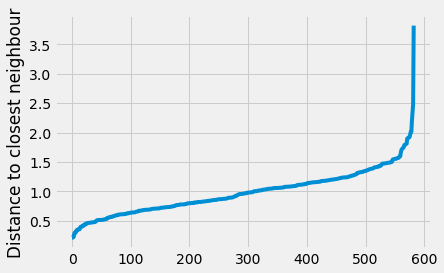

In [92]:
distances_ = np.sort(distances_, axis=0)
distances_ = distances_[:,1]
a = np.array(list(zip(range(len(distances_)), distances_)))

#plt.plot(distances_)
plt.plot(a[:, 0],a[:, 1])
plt.ylabel('Distance to closest neighbour')
plt.savefig('Fig11_DBSCANLiving.png')
plt.show()

In [93]:
# Knee-method
#The optimal value for epsilon is found at the point of maximum curvature.
eps = 1.6

In [94]:
cdmx_central_clustered = cdmx_central.copy().reset_index() # new dataframe
cdmx_central_clustered["LivingCluster"] = DBSCAN(eps=eps, min_samples=5).fit(X_norm).labels_ # get clusters labels
cdmx_central_clustered.head() # show the first five rows of the dataframe

BorNumber  NbhdNumber          Neighborhood   Latitude  Longitude  \
0          2           1              AGUILERA  19.472845 -99.155746   
1          2           2                ALDANA  19.470737 -99.149997   
2          2           3  AMPLIACION PETROLERA  19.483038 -99.195313   
3          2           5         ANGEL ZIMBRON  19.467794 -99.189118   
4          2           6                ARENAL  19.465294 -99.152009   

                                             Geojson       Borough  \
0  {"type": "Polygon", "coordinates": [[[-99.1590...  AZCAPOTZALCO   
1  {"type": "Polygon", "coordinates": [[[-99.1485...  AZCAPOTZALCO   
2  {"type": "Polygon", "coordinates": [[[-99.1966...  AZCAPOTZALCO   
3  {"type": "Polygon", "coordinates": [[[-99.1904...  AZCAPOTZALCO   
4  {"type": "Polygon", "coordinates": [[[-99.1518...  AZCAPOTZALCO   

   CityCluster  HDI_2010  SeismicRiskLevel  TransportStations  \
0            1  0.831271                 1                  4   
1            1  0.806776                 1                  4   
2            1  0.876616                 1                  0   
3            1  0.914462                 1                  1   
4            1  0.727231                 1                  0   

   DistanceTranspStation  HealthCenters  DistanceHealthCenter  FoodShops  \
0             335.854707              1           4091.756843          3   
1             561.212246              1           2938.889240          3   
2            1149.066016              2           2025.007592          6   
3             324.554759              2           3700.616048          5   
4            1669.541636              2           2519.392808          3   

   DistanceFoodShop  RecreationCenters  DistanceRecCenter  LivingCluster  
0        808.729036                 15        1211.301590              0  
1        496.797880                 16        1223.153429              0  
2        575.718203                 12        1342.318518              0  
3       1186.242741                  7         591.374344              0  
4        587.107308                 10        1643.383095              0

In [95]:
# Count number of neighborhoods per cluster
cdmx_count = cdmx_central_clustered.groupby(['LivingCluster']).LivingCluster.agg('count').to_frame('Count')

cdmx_count

Count
LivingCluster       
-1                57
 0               471
 1                51
 2                 4

#### Second visualization: Northern Central Mexico City neighborhoods clustered by living level

Let's visualize the clustered neighborhoods.

In [96]:
# create map
cdmx_map_3 = folium.Map(location=[latitude, longitude], tiles='cartodbpositron', zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, bor, nei, cluster1 in zip(cdmx_central_clustered['Latitude'], cdmx_central_clustered['Longitude'], cdmx_central_clustered['Borough'], cdmx_central_clustered['Neighborhood'], cdmx_central_clustered['LivingCluster']):
    label = folium.Popup('{}  -  {}  -  Cluster {}'.format(bor, nei, cluster1), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=2,
        popup=label,
        color=rainbow[cluster1-1],
        fill=True,
        fill_color=rainbow[cluster1-1],
        fill_opacity=0.7).add_to(cdmx_map_3)
       
cdmx_map_3

#### Clusters Analysis

Let's inspect the distrbutions of the variables used to cluster our neighborhoods..

In [97]:
cdmx_central_clustered.describe()

BorNumber  NbhdNumber    Latitude   Longitude  CityCluster  \
count  583.000000  583.000000  583.000000  583.000000        583.0   
mean     8.487136   80.392796   19.467593  -99.139209          1.0   
std      5.785937   64.797345    0.042581    0.038685          0.0   
min      2.000000    1.000000   19.384709  -99.218718          1.0   
25%      5.000000   34.000000   19.441674  -99.169070          1.0   
50%      5.000000   62.000000   19.467919  -99.137735          1.0   
75%     15.000000  103.500000   19.490678  -99.110856          1.0   
max     17.000000  256.000000   19.581348  -99.053503          1.0   

         HDI_2010  SeismicRiskLevel  TransportStations  DistanceTranspStation  \
count  583.000000        583.000000         583.000000             583.000000   
mean     0.834671          1.300172           2.806175            1663.825182   
std      0.075074          0.760347           3.472300            2472.138781   
min      0.560991          0.000000           0.000000              33.200994   
25%      0.799916          1.000000           0.000000             495.368549   
50%      0.831271          1.000000           1.000000             757.004802   
75%      0.876942          2.000000           5.000000            1452.385794   
max      0.986971          2.000000          17.000000           14422.807523   

       HealthCenters  DistanceHealthCenter   FoodShops  DistanceFoodShop  \
count     583.000000            583.000000  583.000000        583.000000   
mean        1.468268           3233.587695    3.554031        780.129015   
std         1.028096           1749.679570    2.053431        494.707757   
min         0.000000            186.025277    0.000000         34.541880   
25%         1.000000           1947.127900    2.000000        450.931067   
50%         1.000000           2865.972580    4.000000        665.941117   
75%         2.000000           4268.054380    5.000000       1003.698755   
max         5.000000           9521.017418   10.000000       4169.760197   

       RecreationCenters  DistanceRecCenter  LivingCluster  
count         583.000000         583.000000     583.000000  
mean            4.921098        1555.518566       0.003431  
std             5.053047         916.545374       0.461570  
min             0.000000          38.881590      -1.000000  
25%             0.000000         838.234055       0.000000  
50%             4.000000        1409.028908       0.000000  
75%             9.000000        2097.364188       0.000000  
max            17.000000        5172.322690       2.000000

#### Clusters Analysis

Let's inspect the distrbutions of the variables used to cluster our neighborhoods..

In [98]:
data1 = []
vari = list(cdmx_central_clustered.columns)[8:18]
for var in vari:
    xs = []
    for clus in cdmx_count.index:
        xs.append(list(cdmx_central_clustered[cdmx_central_clustered['LivingCluster'] == clus][var]))
    data1.append(xs)

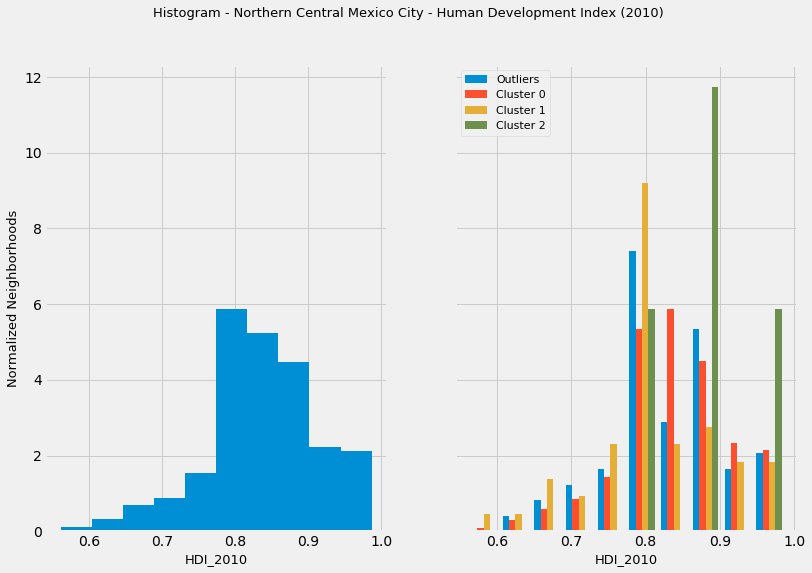

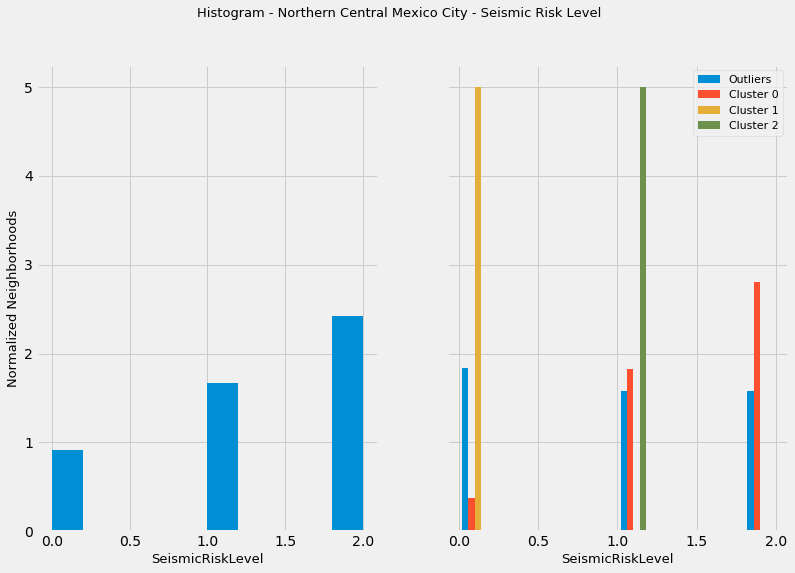

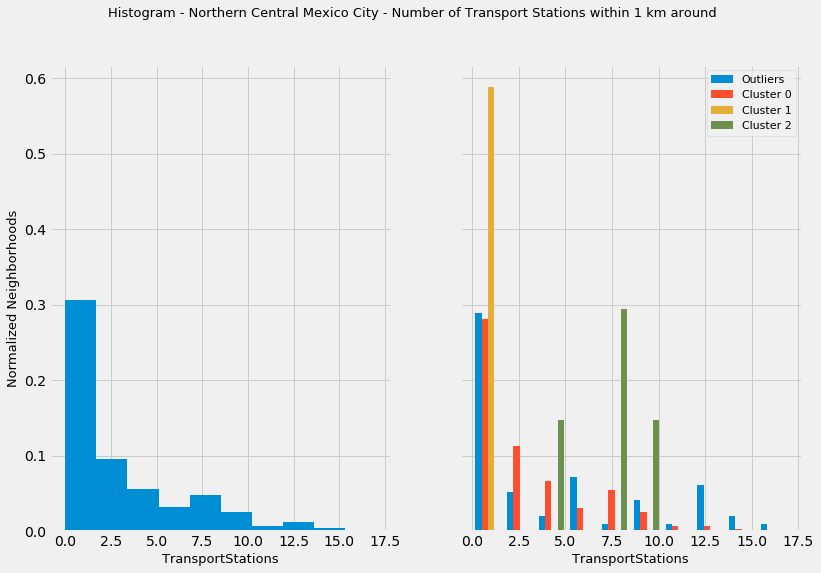

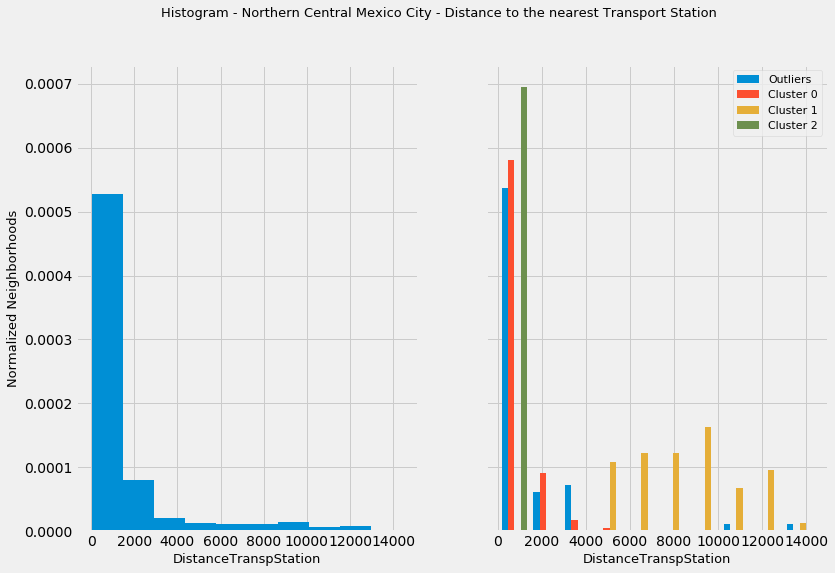

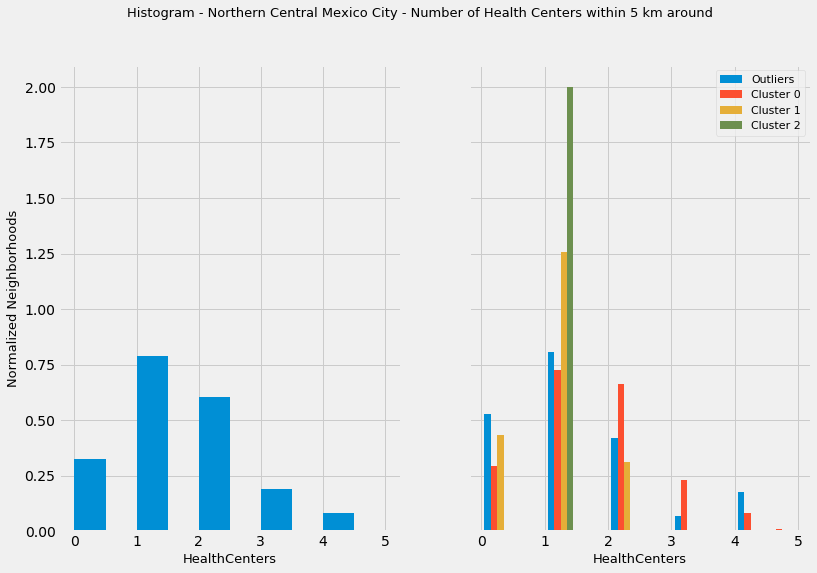

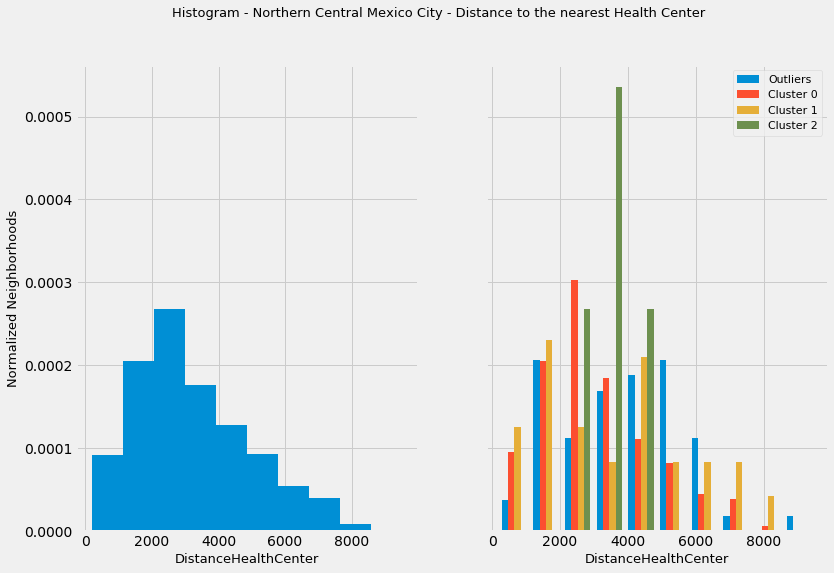

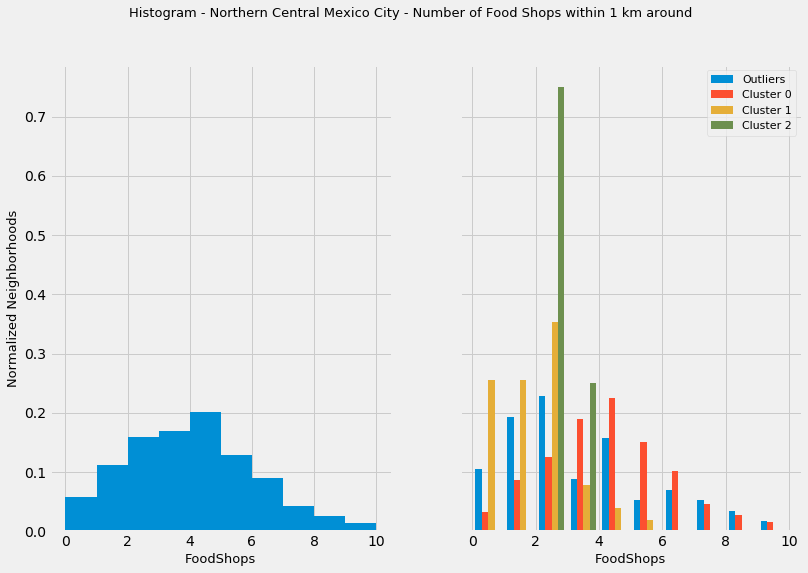

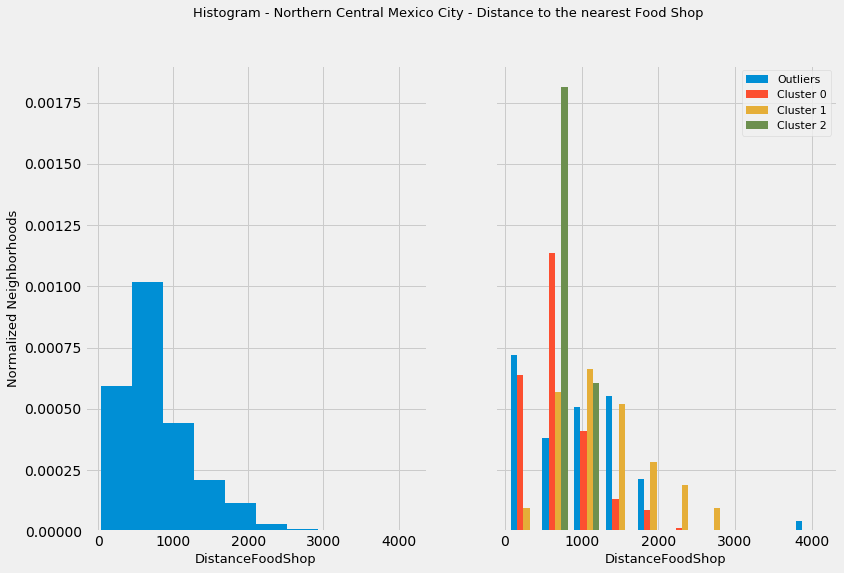

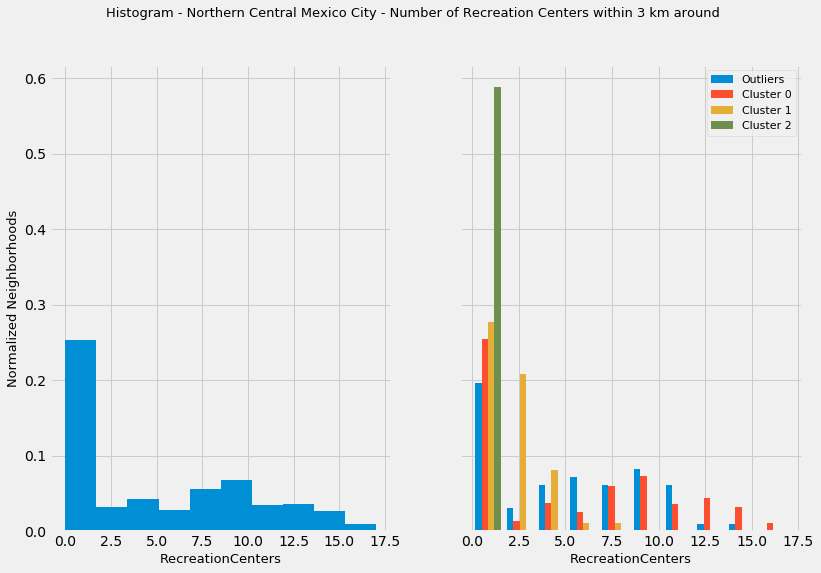

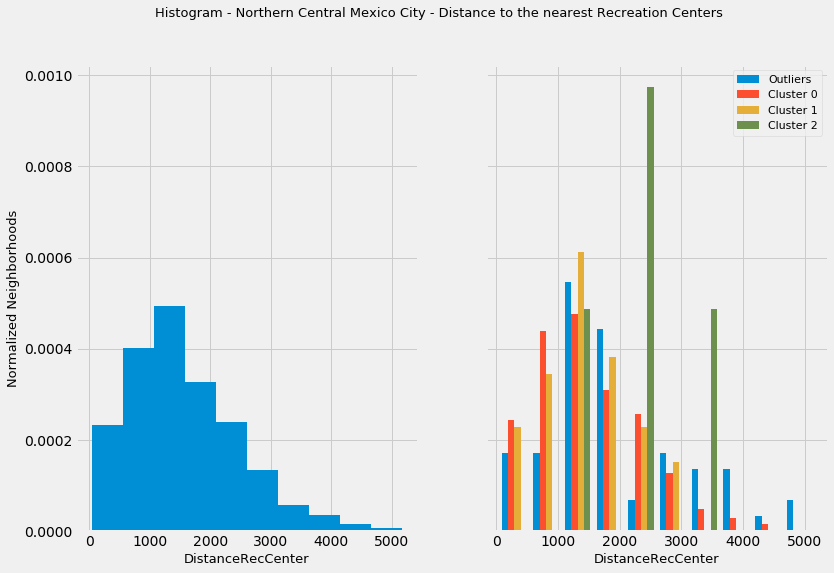

In [99]:
# Assign colors for each airline and the names
labels = ['Outliers', 'Cluster 0', 'Cluster 1', 'Cluster 2']
titles = ['Human Development Index (2010)',
          'Seismic Risk Level',
          'Number of Transport Stations within 1 km around',
          'Distance to the nearest Transport Station',
          'Number of Health Centers within 5 km around ',
          'Distance to the nearest Health Center',
          'Number of Food Shops within 1 km around ',
          'Distance to the nearest Food Shop',
          'Number of Recreation Centers within 3 km around',
          'Distance to the nearest Recreation Centers',]
         
# Make the histogram using a list of lists
# Normalize the flights and assign colors and names

for var in range(len(vari)):
    plt.style.use('fivethirtyeight')
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 8), sharey=True)
    axs[0].hist(cdmx_central_clustered[vari[var]], density=True, label=['Northern Central Mexico City'])
    axs[1].hist(data1[var], density=True, label=labels)
    
    # Plot formatting
    for ax in axs.flat:
        ax.set_xlabel(vari[var], fontsize=13)
        ax.set_ylabel(ylabel='Normalized Neighborhoods', fontsize=13)
        
    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()
    
    axs[1].legend(fontsize=11) # set legend
    
    fig.suptitle('Histogram - Northern Central Mexico City - {}'.format(titles[var]), fontsize=13)
    plt.savefig('Fig{}_{}.png'.format(var, vari[var]))
    plt.show()

#### Bonus Visualizations

In [100]:
transport.insert(5, 'Icon', 'car')
health.insert(3, 'Icon', 'heart')

In [101]:
transport.head(1)

Transport   Latitude  Longitude   Station                      Line Icon
0     Metro  19.422887 -99.102817  Balbuena  Observatorio - Pantitlán  car

In [102]:
health.head(1)

Latitude  Longitude                    HealthCentre   Icon
0  19.356548 -99.107689  Hospital Pediátrico Iztapalapa  heart

In [103]:
foodshops = pd.DataFrame(coords_foodshop[::-1], columns = ['Latitude', 'Longitude'])
recreation = pd.DataFrame(coords_reccenters[::-1], columns = ['Latitude', 'Longitude'])
foodshops.insert(2, 'Icon', 'cart')
recreation.insert(2, 'Icon', 'soccer')

In [104]:
foodshops.head(1)

Latitude  Longitude  Icon
0 -99.121099  19.443398  cart

In [105]:
recreation.head(1)

Latitude  Longitude    Icon
0 -99.159177  19.420216  soccer

...and let's now save/persist all our data into a local file.

In [106]:
transport.to_csv(r'Results_Transport.csv')
health.to_csv(r'Results_Health.csv')
foodshops.to_csv(r'Results_FoodShops.csv')
recreation.to_csv(r'Results_Recreation.csv')
risk.to_csv(r'Results_Seismic.csv')

In [107]:
cdmx_central_clustered.to_csv(r'Results_FinalAnalysis.csv')
data.to_csv(r'Results_CDMXData.csv')

## Results and Discussion <a name="results"></a>

As we can see, cluster 0 represents most of the neighborhoods, as its distributions emulate the general ones. Cluster 0 describes a specific part of the city where seismic risk is low compared with the majority and where transport stations, health centers, food shops, and recreation centers are far away. Finally, cluster 2 groups only four neighborhoods of the city that stand out among the rest. These are Defensores de la República, Popotla, Hipódromo and Anzures, which have a HDI score bigger than the average, suitable seismic risk level and a good number of nearby transport stations, health centers, food shops, and recreation centers.


## Conclusion <a name="conclusion"></a>

The purpose of this project was to identify the optimal places to live in Mexico City according to factors that could influence people to move to a particular area. Clustering of neighborhoods was then performed in order to create a tool to sustain that kind of decisions and insights that were starting points for exploration by stakeholders.

The final decision on optimal house location will be made by stakeholders based on specific characteristics of neighborhoods and locations in every recommended zone, taking into consideration additional factors proximity to major roads, real estate availability, prices, social and economic dynamics of every neighborhood, etc.